In [2]:
%load_ext autoreload

In [41]:
%autoreload 2
%matplotlib inline

from pymongo import MongoClient
import pymongo
import sys, os, re
import json
from urllib.parse import urlparse
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint

import config
from utils import plot, url_utils, plotly_utils

db = MongoClient(config.MONGO_HOSTNAME).web_decay

## CDF of #urls broken across year
- Broken: non 200 status code

2019
2014
2009
2004
1999


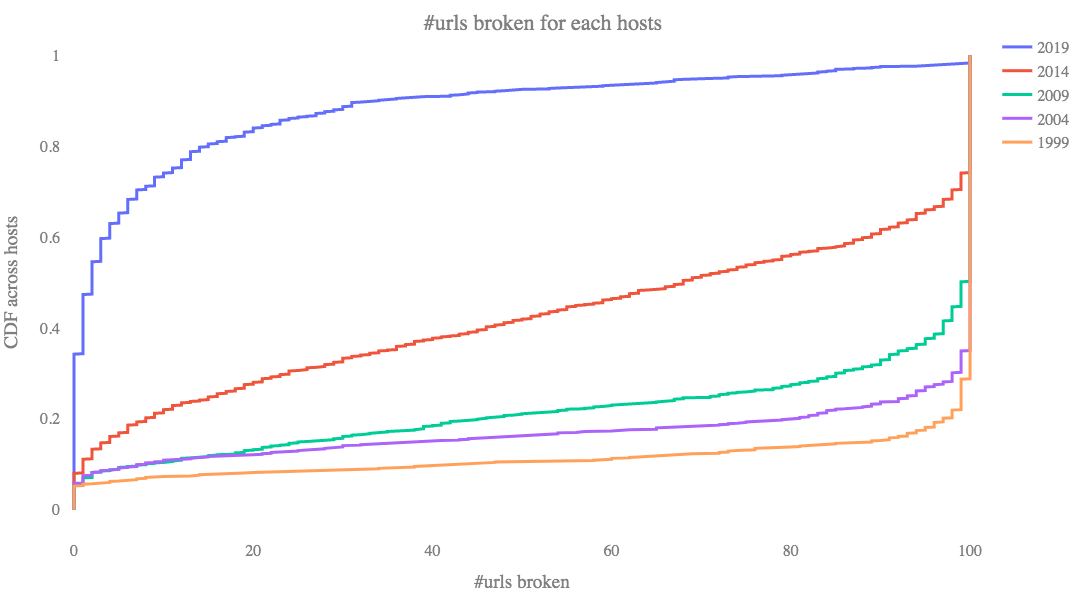

In [113]:
years = [1999, 2004, 2009, 2014, 2019]
df = pd.DataFrame()
all_not_broken = []
for year in reversed(years):
    print(year)
    missing_count = []
    hosts = db.url_status_implicit_broken.aggregate([
        {"$match": {"year": year}},
        {"$group": {"_id": "$hostname"}}
    ])
    for host in hosts:
        count = db.url_status_implicit_broken.count_documents({"year": year, "hostname": host['_id'], "detail": "no redirection"})
        missing_count.append(100 - count)
        if count == 100: all_not_broken.append({"host": host['_id'], "year": year})
    df[year] = missing_count
json.dump(all_not_broken, open("tmp/all_not_broken.json", 'w+'))
plotly_utils.plot_CDF(df, xtitle="#urls broken", ytitle="CDF across hosts", title="#urls broken for each hosts")

## #status for urls share the same path
- Each path has at least 3 urls

{'2019': 406, '2014': 1612, '2009': 2227, '2004': 2269, '1999': 3047}


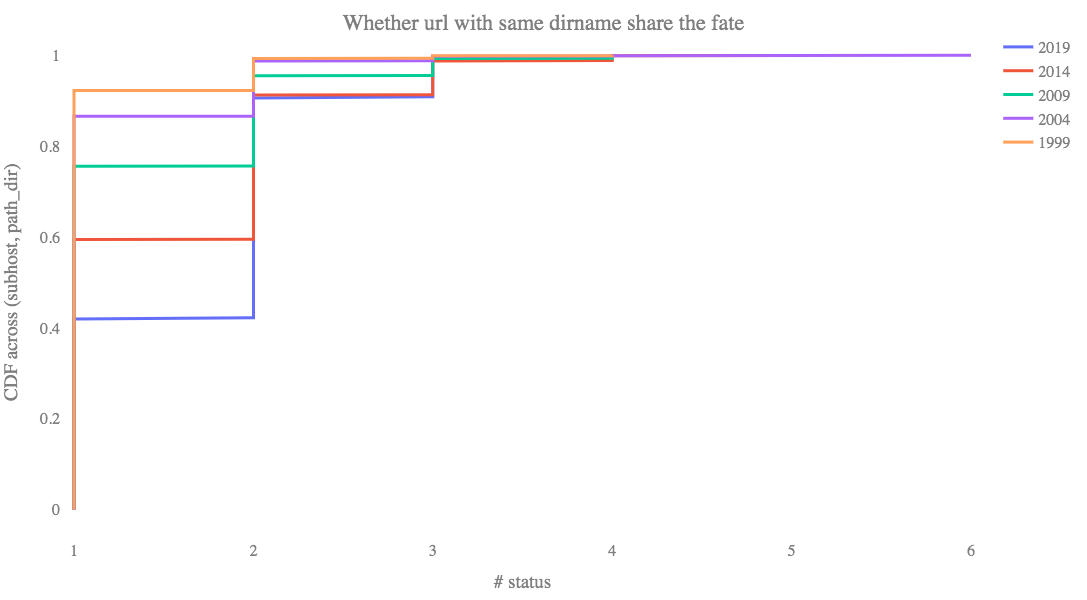

In [115]:
fate = defaultdict(list)
years = [1999, 2004, 2009, 2014, 2019]
for year in reversed(years):
    hosts = db.url_status_implicit_broken.aggregate([
        {"$match": {"year": year}},
        {"$group": {"_id": "$hostname"}}
    ])
    for i, host in enumerate(list(hosts)):
        path_fate = defaultdict(list)
        urls = db.url_status_implicit_broken.find({"hostname": host['_id'], "year": year})
        for url in urls:
            up = urlparse(url['url'])
            subhost, path, query = up.netloc, up.path, up.query
            if path == '': path = '/'
            elif path[-1] == '/' and path != '/': path = path[:-1]
            dirname = os.path.dirname(path)
            path_fate["{}|{}".format(subhost, dirname)].append(url_utils.status_categories(url['status'], url['detail']))
        dir_count = {}
        for _, url_status in path_fate.items():
            if len(url_status) >= 3 and '4/5xx' in url_status:
                fate[str(year)].append(len(set(url_status)))
fate_df = pd.concat([pd.DataFrame({k: v}) for k, v in fate.items()], axis=1)
print({k: len(v) for k, v in fate.items()})
plotly_utils.plot_CDF(fate_df, xtitle='# status', ytitle='CDF across (subhost, path_dir)',\
                      title='Whether url with same dirname share the fate')

In [ ]:
fate = defaultdict(dict)
hosts = db.url_status_implicit_broken.aggregate([
    {"$group": {"_id": "$hostname"}}
])
focus_status = ["4/5xx", "non-home redirection"]
for i, host in enumerate(list(hosts)):
    path_fate = defaultdict(list)
    urls = db.url_status_implicit_broken.find({"hostname": host['_id']})
    for url in urls:
        up = urlparse(url['url'])
        subhost, path, query = up.netloc, up.path, up.query
        if path == '': path = '/'
        elif path[-1] == '/' and path != '/': path = path[:-1]
        dirname = os.path.dirname(path)
        path_fate["{}|{}".format(subhost, dirname)].append((url['url'], url_utils.status_categories(url['status'], url['detail'])))
    dir_count = {}
    for dirname, url_status in path_fate.items():
        if len(url_status) >= 3:
            dir_count[dirname] = (set([u[1] for u in url_status]), url_status)
    fate[host['_id']] = dir_count
fate_count, fate_urls = defaultdict(int), defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
for hostname, dir_count in fate.items():
    for dirname, (statuss, urls) in dir_count.items():
        fate_df = fate_df.append({'num_status': len(statuss)}, ignore_index=True)
        if len(statuss) > 1:
            fate_count[tuple(sorted(list(statuss)))] += 1
            fate_urls[tuple(sorted(list(statuss)))][hostname][dirname] = urls
fate_urls = fate_urls[tuple(sorted(focus_status))]
json.dump(fate_urls, open('broken_pages/fate_urls.json', 'w+'))
fate_count = [list(k) + [v] for k, v in fate_count.items()]
fate_count.sort(key=lambda x: x[-1], reverse=True)
json.dump(fate_count, open('broken_pages/fate_count.json', 'w+') )

#### Some high multi-status compinations:

In [ ]:
[
  ["4/5xx", "no redirection", 721],
  ["4/5xx", "non-home redirection", 395],
  ["no redirection", "non-home redirection", 295],
  ["4/5xx", "OtherError_Ping failure", 128],
  ["4/5xx", "no redirection", "non-home redirection", 127],
  ["OtherError_80_open_443_open", "no redirection", 96],
  ["OtherError_Ping failure", "no redirection", 89]
]

### url update breakdown

In [116]:
pprint(list(db.url_update.aggregate([ {"$group": {"_id": "$detail", "total": {"$sum": 1}}}])))

[{'_id': 'no html', 'total': 7601},
 {'_id': '1 snapshot', 'total': 90245},
 {'_id': 'not similar', 'total': 21947},
 {'_id': 'HLD', 'total': 9970},
 {'_id': 'no content', 'total': 21821},
 {'_id': 'similar', 'total': 89187},
 {'_id': 'no contents', 'total': 15511}]


## 200 Stauts code broken rate
- Categorized as broken, unsure, and good
- urls with no similarities are considered as unsure

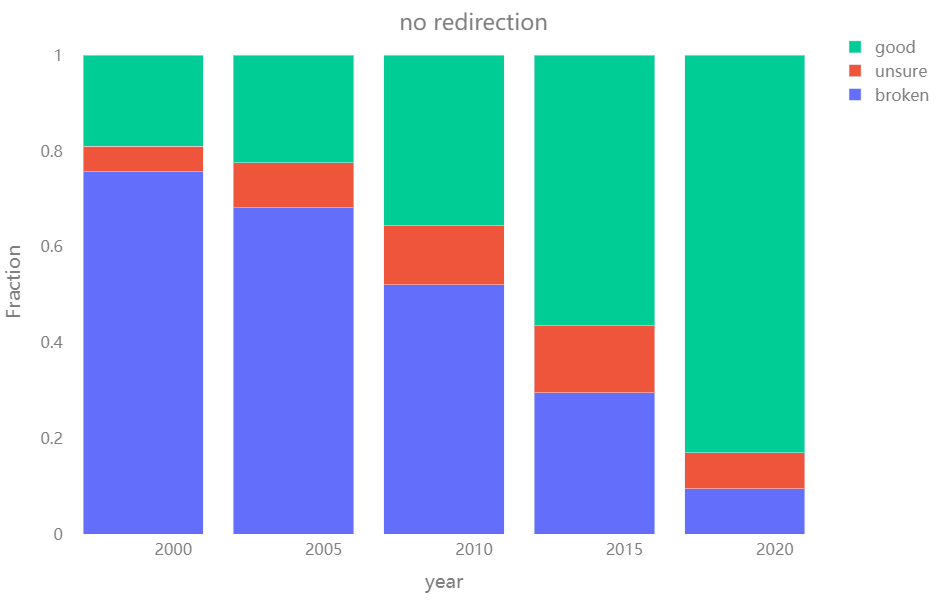

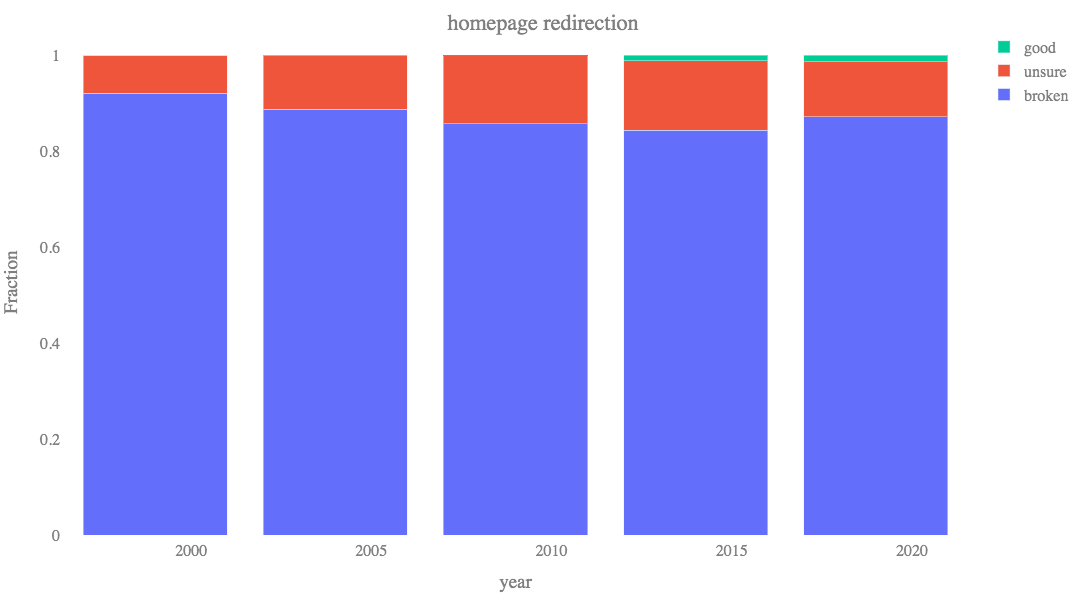

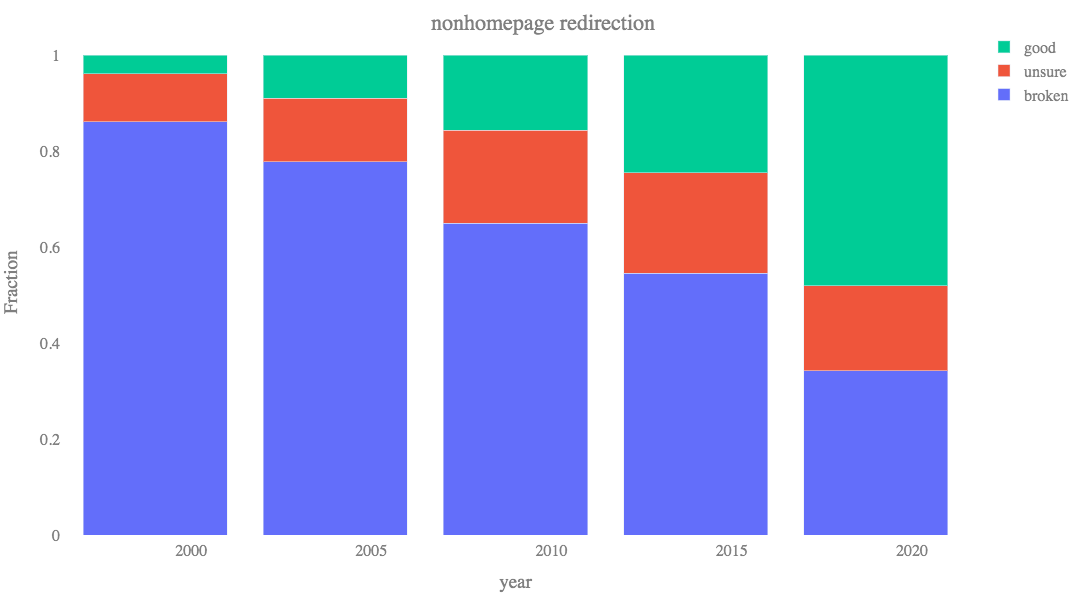

In [71]:
years = [1999, 2004, 2009, 2014, 2019]
df_template = pd.DataFrame({"broken":[0 for _ in years], 'unsure':[0 for _ in years], 'good': [0 for _ in years], 'year': years})
df_template.set_index('year', inplace=True)
indexes = ['no redirection', 'homepage redirection', 'non-home redirection']
total = [df_template.copy() for _ in range(3)]
noredir, home, nonhome = total
# urls_2xx = db.url_status_implicit_broken.find({'status': re.compile('^[23]')})
urls_2xx = db.url_update.aggregate([
    {"$match": {"updating": False, "detail": re.compile("^(similar|1 snapshot)")}},
    {"$lookup": {
        "from": "url_status_implicit_broken",
        "localField": "_id",
        "foreignField": "_id",
        "as": "implicits"
    }},
    {"$unwind": "$implicits"},
    {"$replaceRoot": {"newRoot": "$implicits"}}
])
for url_2xx in urls_2xx:
    label = ''
    if 'similarity' not in url_2xx: label = 'unsure'
    elif url_2xx['similarity'] >= 0.8: label = 'good'
    elif url_2xx['similarity'] <= 0.2: label = 'broken'
    else: label = 'unsure'
    year, detail = url_2xx['year'], url_2xx['detail']
    total[indexes.index(detail)].loc[year, label] += 1
plotly_utils.plot_bar(noredir, xtitle='year', ytitle='Fraction', title='no redirection', stacked=True, unified=True)
plotly_utils.plot_bar(home, xtitle='year', ytitle='Fraction', title='homepage redirection', stacked=True, unified=True)
plotly_utils.plot_bar(nonhome, xtitle='year', ytitle='Fraction', title='nonhomepage redirection', stacked=True, unified=True)

## Similarity on searched results of broken page
- Broken page contains 45xx, DNS, home-redirect, nonhome-redirect, and no-redirect

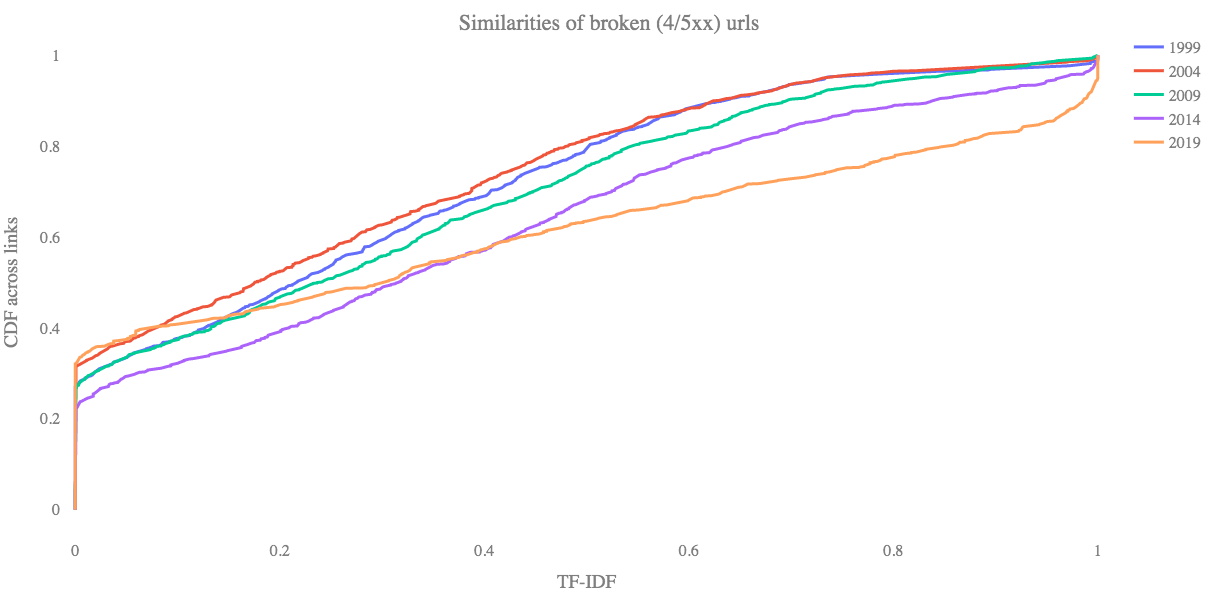

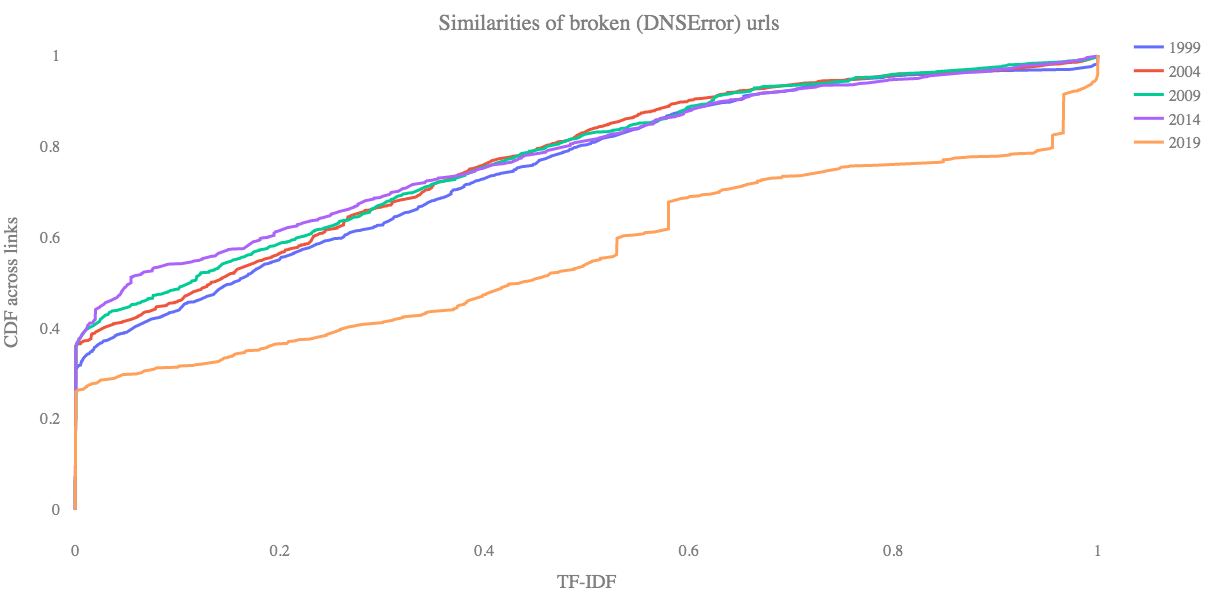

In [123]:
searched_urls = db.search_meta.aggregate([
    {"$match": {"usage": "represent"}},
    {"$lookup": {
        "from": "url_broken",
        "localField": "url",
        "foreignField": "_id",
        "as": "stat"
    }},
    {"$project": {"_id": False, 'url': True, 'stat': True, 'similarity': True}},
])

simi_dict = defaultdict(lambda: defaultdict(list))
for obj in list(searched_urls):
    url, simi, stat = obj['url'], obj['similarity'], obj['stat'][0]
    status = url_utils.status_categories(stat['status'], stat['detail'])
    simi_dict[status][str(stat['year'])].append(simi)
for status, year_simi in simi_dict.items():
    df = pd.concat([pd.DataFrame({k: year_simi[k]}) for k in sorted(year_simi)], axis=1)
    plotly_utils.plot_CDF(df, xtitle='TF-IDF', ytitle="CDF across links", title='Similarities of broken ({}) urls'.format(status))

#### Get sample of certain status urls with certain search results (good/broken/unsure)

In [ ]:
match = db.url_broken.aggregate([
    {"$match": {"status": re.compile("^[45xx]")}},
    {"$lookup": {
        "from": "search_meta",
        "let": {"id": "$_id"},
        "pipeline": [
            {"$match": {"usage": "represent", "similarity": {"$gte": 0.8}}},
            {"$match": {"$expr": {"$and": [
                {"$eq": ["$url", "$$id"]}
            ]}}}
        ],
        "as": "searched"
    }},
    {"$match": {"searched.0": {"$exists": True}}},
    {"$unwind": "$searched"},
    {"$project": {"searched_url": "$searched.searched_url", "similairty": "$searched.similarity", "year": True, "status": True}}
])

json.dump(list(match), open("search/match.json", 'w+'))

#### How many broken urls that can be content searched belong to the same host?

In [86]:
host_extractor = url_utils.HostExtractor()
years = [1999, 2004, 2009, 2014, 2019]
headers = ['45xx', "DNS"]
filters = [re.compile("^[45xx]"), re.compile("DNSError")]
df = pd.DataFrame({})
for year in years:
    year_dict = {'year': [year]}
    for h, f in zip(headers, filters):
        match = db.url_broken.aggregate([
            {"$match": {"status": f, "year": year}},
            {"$lookup": {
                "from": "search_meta",
                "let": {"id": "$_id"},
                "pipeline": [
                    {"$match": {"usage": "represent", "similarity": {"$gte": 0.8}}},
                    {"$match": {"$expr": {"$and": [
                        {"$eq": ["$url", "$$id"]}
                    ]}}}
                ],
                "as": "searched"
            }},
            {"$match": {"searched.0": {"$exists": True}}},
            {"$unwind": "$searched"},
            {"$project": {"searched_url": "$searched.searched_url", "similairty": "$searched.similarity", "year": True, "status": True}}
        ])
        match = list(match)
        total, count = len(match), 0
        for url in match:
            orig_host = host_extractor.extract(url['_id'])
            search_host = host_extractor.extract(url['searched_url'])
            if orig_host == search_host: count += 1
        year_dict[h] = [count / total]
        year_dict[h+'_total'] = [total]
    df = df.append(pd.DataFrame(year_dict))
df = df.set_index('year')
print(df)

          45xx  45xx_total       DNS  DNS_total
year                                           
1999  0.125000          40  0.021277         47
2004  0.361111          36  0.000000         43
2009  0.357143          56  0.047619         42
2014  0.436364         110  0.111111         54
2019  0.477477         222  0.201117        179


#### For definite reconsturcted urls, what are their same path urls' fate?

4
9
24
55
110
110 192


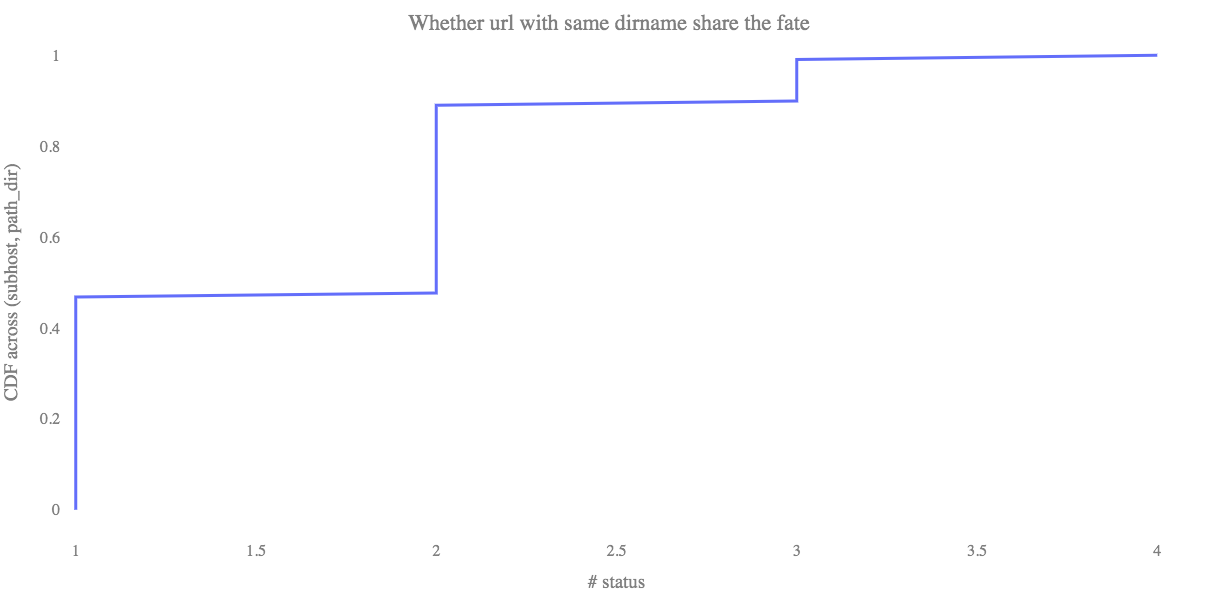

In [121]:
host_extractor = url_utils.HostExtractor()
years = [1999, 2004, 2009, 2014, 2019]
headers = ['45xx']
filters = [re.compile("^[45xx]")]
df = pd.DataFrame({})
status, count = [], 0
fate = {}
for year in years:
    year_dict = {'year': [year]}
    for h, f in zip(headers, filters):
        match = db.url_broken.aggregate([
            {"$match": {"status": f, "year": year}},
            {"$lookup": {
                "from": "search_meta",
                "let": {"id": "$_id"},
                "pipeline": [
                    {"$match": {"usage": "represent", "similarity": {"$gte": 0.8}}},
                    {"$match": {"$expr": {"$and": [
                        {"$eq": ["$url", "$$id"]}
                    ]}}}
                ],
                "as": "searched"
            }},
            {"$match": {"searched.0": {"$exists": True}}},
            {"$unwind": "$searched"},
            {"$project": {"searched_url": "$searched.searched_url", "similairty": "$searched.similarity", "year": True, "status": True}}
        ])
        match = list(match)
        for url in match:
            orig_host = host_extractor.extract(url['_id'])
            search_host = host_extractor.extract(url['searched_url'])
            if orig_host == search_host:
                count += 1
                path = urlparse(url['_id']).path
                if path == '': path += '/'
                elif path[-1] == '/' and path != '/': path = path[:-1]
                dirr = os.path.dirname(path)
                same_path = list(db.url_status_implicit_broken.find({"_id": re.compile(dirr), "hostname": orig_host, 'year': year}))
                for i in range(len(same_path)):
                    if same_path[i]['url'] == url['_id']: same_path[i]['searched_url'] = url['searched_url']
                if len(same_path) >= 2:
                    status.append(len(set([url_utils.status_categories(sp['status'], '') for sp in same_path])))
                    fate['{}|{}'.format(orig_host, path)] = same_path
        print(len(status))
print(len(status), count)
json.dump(fate, open('tmp/searched_45xx_path_fate.json', 'w+'))
plotly_utils.plot_CDF(pd.DataFrame({'num': status}), xtitle='# status', ytitle='CDF across (subhost, path_dir)',\
                      title='Whether url with same dirname share the fate')